In [1]:
#imports
import os
import scienceplots
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from tqdm import tqdm

from mrmr import mrmr_regression

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
torch.manual_seed(4000)
np.random.seed(42)

#### Data

In [2]:
df=pd.read_csv('C:\\Users\\lucas\\Downloads\\laohuaYM_noAvg(2).csv',header=None,skiprows=1)
df_sorted=df.sort_values(by=1845)

train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for i in range(len(df)):
    if (i % 5) == 4:  # Adding every 5th row to the test_df
        test_df = pd.concat([test_df, df.iloc[[i]]], ignore_index=True)
    else:  # add other rows train
        train_df = pd.concat([train_df, df.iloc[[i]]], ignore_index=True)
        
x_train=train_df.iloc[:,0:1845]
y_train=train_df.iloc[:,1845]
x_test=test_df.iloc[:,0:1845]
y_test=test_df.iloc[:,1845]

x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [2]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

In [3]:
#remove missing values
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [4]:
#data split and normalisation
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [5]:
#norm
scaler_x = StandardScaler()
scaler_x.fit(x_train)
x_train=scaler_x.transform(x_train)
x_test=scaler_x.transform(x_test)

scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [6]:
x_train=pd.DataFrame(x_train)
y_train=pd.Series(y_train.ravel())

x_test=pd.DataFrame(x_test)
y_test=pd.Series(y_test.ravel())

In [8]:
x_test.shape

(79, 401)

### CNN

In [8]:
#NN class    
class Inception(nn.Module):
    def __init__(self, out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3,stride_3,hidden_size,dropout_rate,total_features):
        super(Inception,self).__init__()
        
        #leakyrelu
        self.leaky_relu=nn.LeakyReLU()
        
        #this conv is common to every branch
        self.conv1=nn.Conv1d(in_channels=1,out_channels=out_channels_1,kernel_size=kernel_1,stride=stride_1)
        
        #branch 1, conv1, x1
        self.branch1_2 = nn.Conv1d(in_channels=out_channels_1,
                                   out_channels=out_channels_2,
                                   kernel_size=1,
                                   stride=1) #1x1

        #branch 2, conv1, x1, conv_1
        #same conv1
        self.branch2_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1) #1x1
        self.branch2_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)

        #brnach 2 conv1, x1, conv_2
        #same conv1
        self.branch3_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1) #1x1
        self.branch3_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)

        #branch 2 conv1, pool, x1
        #same conv1
        self.branch4_2 = nn.MaxPool1d(kernel_size=kernel_2, stride=stride_2)
        self.branch4_3 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1) #1x1
        
        #flatten
        self.flatten = nn.Flatten()
        
        #layers
        self.F1=nn.Linear(total_features,hidden_size)
        self.output=nn.Linear(hidden_size,1)
        
        #batch norm
        self.bn1=nn.BatchNorm1d(total_features) #after flatten
        self.bn2=nn.BatchNorm1d(hidden_size) #after f1
        
        #dropout
        self.dropout=nn.Dropout(p=dropout_rate)
        
        
        # scheduler = StepLR(optimizer, step_size=?, gamma=0.1) step is not referred in article
        # variance scaling for weight initialization
        
        
    def forward(self,x):
        origin = self.leaky_relu(self.conv1(x))
        
        branch1 = self.leaky_relu(self.branch1_2(origin))
        branch2 = self.leaky_relu(self.branch2_3(self.leaky_relu(self.branch2_2(origin))))
        branch3 = self.leaky_relu(self.branch3_3(self.leaky_relu(self.branch3_2(origin))))
        branch4 = self.leaky_relu(self.branch4_3(self.branch4_2(origin))) 
        
        # Flatten each branch output  
        flat_branch1 = self.flatten(branch1)
        flat_branch2 = self.flatten(branch2)
        flat_branch3 = self.flatten(branch3)            #need to flat then concat becausse output sizes are no the same...
        flat_branch4 = self.flatten(branch4)
        
        # Concatenate the flattened branches
        concat = torch.cat([flat_branch1, flat_branch2, flat_branch3, flat_branch4], dim=1)
        
        F1_out=self.leaky_relu(self.bn2((self.F1(concat))))  #f1, then batch, then leakyrelu, paper does not states, but afaik batch norm before relu will benefit the most out of relu...
        
        F1_out=self.dropout(F1_out)
        
        output=self.output(F1_out)
        
        return output
        
        

In [36]:
###with xavier
class Inception(nn.Module):

    def __init__(self, out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3, stride_3, hidden_size, dropout_rate, total_features):
        super(Inception, self).__init__()

        # LeakyReLU
        self.leaky_relu = nn.LeakyReLU()

        # Common conv1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels_1, kernel_size=kernel_1, stride=stride_1)
        nn.init.xavier_uniform_(self.conv1.weight)

        # Branch 1
        self.branch1_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch1_2.weight)

        # Branch 2
        self.branch2_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch2_2.weight)
        self.branch2_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)
        nn.init.xavier_uniform_(self.branch2_3.weight)

        # Branch 3
        self.branch3_2 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch3_2.weight)
        self.branch3_3 = nn.Conv1d(in_channels=out_channels_2, out_channels=out_channels_3, kernel_size=kernel_3, stride=stride_3)
        nn.init.xavier_uniform_(self.branch3_3.weight)

        # Branch 4
        self.branch4_2 = nn.MaxPool1d(kernel_size=kernel_2, stride=stride_2)
        self.branch4_3 = nn.Conv1d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=1, stride=1)
        nn.init.xavier_uniform_(self.branch4_3.weight)

        # Flatten
        self.flatten = nn.Flatten()

        # Layers
        self.F1 = nn.Linear(total_features, hidden_size)
        nn.init.xavier_uniform_(self.F1.weight)
        self.output = nn.Linear(hidden_size, 1)
        nn.init.xavier_uniform_(self.output.weight)

        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(total_features)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        origin = self.leaky_relu(self.conv1(x))

        branch1 = self.leaky_relu(self.branch1_2(origin))
        branch2 = self.leaky_relu(self.branch2_3(self.leaky_relu(self.branch2_2(origin))))
        branch3 = self.leaky_relu(self.branch3_3(self.leaky_relu(self.branch3_2(origin))))
        branch4 = self.leaky_relu(self.branch4_3(self.branch4_2(origin)))

        # Flatten each branch output
        flat_branch1 = self.flatten(branch1)
        flat_branch2 = self.flatten(branch2)
        flat_branch3 = self.flatten(branch3)
        flat_branch4 = self.flatten(branch4)

        # Concatenate the flattened branches
        concat = torch.cat([flat_branch1, flat_branch2, flat_branch3, flat_branch4], dim=1)

        F1_out = self.leaky_relu(self.bn2(self.F1(concat)))
        F1_out = self.dropout(F1_out)

        output = self.output(F1_out)

        return output

In [164]:
#NN single conv dataset 1
class Inception(nn.Module):
    def __init__(self, out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3, stride_3, hidden_size, dropout_rate, total_features):
        super(Inception,self).__init__()
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels_1, kernel_size=kernel_1, stride=stride_1)
        self.activconv=nn.LeakyReLU()
        self.flatten=nn.Flatten()
        
        self.linear1=nn.Linear(total_features,4)
        self.activation1=nn.ReLU()
        self.linear2=nn.Linear(4,4)
        self.activation2=nn.ReLU()
        self.linear3=nn.Linear(4,1)
        
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.linear1(self.flatten(x))
        x=self.activation1(x)
        x=self.linear2(x)
        x=self.activation2(x)
        x=self.linear3(x)
        return x

In [338]:

class Inception(nn.Module):
    def __init__(self, out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3, stride_3, hidden_size, dropout_rate, total_features):
        super(Inception, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels_1, kernel_size=kernel_1, stride=stride_1)
        self.flatten = nn.Flatten()
        self.activ_conv = nn.LeakyReLU()
        
        self.linear1 = nn.Linear(total_features, 6)
        self.activation1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(6, 6)
        self.activation2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(6, 1)
              
    def forward(self, x):
        x = self.activ_conv(self.conv1(x))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

# Example usage
# model = NeuralNetwork(out_channels_1, kernel_1, stride_1, out_channels_2, kernel_2, stride_2, out_channels_3, kernel_3, stride_3, hidden_size, dropout_rate, total_features)


#### CNN Support functions

In [37]:
# Adjust make_loader to ensure the data has the correct shape
def make_loader(X, y, batch):
    if not isinstance(X, pd.DataFrame):
        try:
            X = pd.DataFrame(X)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y, pd.Series):
        try:
            y = pd.Series(y)
        except ValueError:
            print("y cannot be converted to a pandas Series.")        
    
    # Ensure the input tensor has the shape (batch_size, channels, sequence_length)
    x_tensor = torch.tensor(X.values, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    set_object = TensorDataset(x_tensor, y_tensor)
    loader_object = DataLoader(dataset=set_object, batch_size=batch)
    return loader_object


In [38]:
def r2_score_model(model, loader):
    true_values = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in loader:
            outputs = model(inputs)  # Get model predictions
            predictions.extend(outputs.numpy())  # Store predictions
            true_values.extend(labels.numpy())  # Store true labels
    
    # Calculate R^2 score
    return r2_score(true_values, predictions)

In [39]:
#evaluate once
def evaluate(Loader, model, loss_fn):
    model.eval()
    loss_sum=0
    with torch.no_grad():
        for batch, (X,y) in enumerate(Loader):
            pred=model(X)
            loss=loss_fn(pred,y.unsqueeze(1))
            loss_sum+=loss.item()
            
    loss_sum/=len(Loader)
    
    return loss_sum

In [40]:
#train a single epoch
def train_one_epoch(TrainLoader, model, loss_fn, optimizer):
    model.train() 
    #train for every example in the dataloader
    for X_train,y_train in TrainLoader:
            
        pred_train=model(X_train)
        loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    return model

In [41]:
#early stop criterion
class EarlyStopper:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.last_loss = float('inf')

    def early_stop(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        elif loss > self.last_loss:  # Spike detection
            pass  # Do nothing if a spike is detected
        else:
            self.counter += 1  # Increment if no improvement or no spike
            if self.counter >= self.patience:
                return True
        
        self.last_loss = loss
        return False

In [42]:
#train and store all errors =)
def train_fn(TrainLoader, TestLoader, model, loss_fn, optimizer,epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]

    
    for epoch in range(epochs):
        model.train() 
        #train for every example in the dataloader
        for X_train,y_train in TrainLoader:
            
            pred_train=model(X_train)
            loss_train=loss_fn(pred_train,y_train.unsqueeze(1))
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
    return model, train_loss_epochs, test_loss_epochs

In [43]:
#train and store all errors =)
def train_early_stop(TrainLoader, TestLoader, model, loss_fn, optimizer,max_epochs):
    train_loss_epochs=[]
    test_loss_epochs=[]
    
    model.train() 
    
    early_stopper = EarlyStopper(patience=250, min_delta=0.00001)
    
    for epoch in range(max_epochs):
        #train for every example in the dataloader
        model=train_one_epoch(TrainLoader=TrainLoader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    
        loss_train_curr_epoch=evaluate(TrainLoader,model,loss_fn)
        train_loss_epochs.append(loss_train_curr_epoch)
       
        loss_test_curr_epoch=evaluate(TestLoader,model,loss_fn)
        test_loss_epochs.append(loss_test_curr_epoch)
        
        if early_stopper.early_stop(loss=loss_train_curr_epoch):        
            break
        
    return model, train_loss_epochs, test_loss_epochs

In [44]:
def ini_model(epochs, learning_rate, out_channels_1, kernel_1,
              stride_1, out_channels_2, kernel_2, stride_2, out_channels_3,
              kernel_3, stride_3, hidden_size, dropout_rate, total_features, regularization_coeff):
    torch.manual_seed(42)

    model = Inception(out_channels_1=out_channels_1,
                      kernel_1=kernel_1,
                      stride_1=stride_1,
                      out_channels_2=out_channels_2,
                      kernel_2=kernel_2,
                      stride_2=stride_2,
                      out_channels_3=out_channels_3,
                      kernel_3=kernel_3,
                      stride_3=stride_3,
                      hidden_size=hidden_size,
                      dropout_rate=dropout_rate,
                      total_features=total_features)

    # Apply Xavier initialization to the model parameters
    def init_weights(m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    model.apply(init_weights)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=regularization_coeff)

    return model, loss_fn, optimizer, epochs

### Benchmark

In [83]:
out_channels_1=8
out_channels_2=4
out_channels_3=4

kernel_1=9
kernel_2=5
kernel_3=7
stride_1=5
stride_2=3
stride_3=1
hidden_size=40
batch_size=1000
dropout_rate=0.25
regularization_coeff=0.001
learning_rate=0.0001
lr_decay=0.001


In [81]:
#tablet
out_channels_1=4
kernel_1=10
stride_1=2

batch_size=64
learning_rate=0.0004
regularization_coeff=0.001
regularization_coeff=0.001

In [84]:
###need to calc the number of feature for linear
features_ini=x_train.shape[1]

branch1=(features_ini-kernel_1)//stride_1+1
branch1=branch1*out_channels_1


total_features = branch1 #+ branch2 + branch3 + branch4

In [85]:
###need to calc the number of feature for linear
features_ini=x_train.shape[1]

branch1=(features_ini-kernel_1)//stride_1+1
branch1=(branch1-1)//1+1
branch1=branch1*out_channels_3

branch2=(features_ini-kernel_1)//stride_1+1
branch2=(branch2-1)//1+1
branch2=(branch2-kernel_3)//stride_3+1
branch2=branch2*out_channels_3

branch3=(features_ini-kernel_1)//stride_1+1
branch3=(branch3-1)//1+1
branch3=(branch3-kernel_3)//stride_3+1
branch3=branch3*out_channels_3

branch4=(features_ini-kernel_1)//stride_1+1
branch4=(branch4-kernel_2)//stride_2+1
branch4=(branch4-1)//1+1
branch4=branch4*out_channels_3

total_features = branch1 + branch2 + branch3 + branch4

In [86]:
total_features

1000

In [87]:
train_loader=make_loader(X=x_train,y=y_train,batch=batch_size)
test_loader=make_loader(X=x_test,y=y_test,batch=batch_size)

epochs=300

model,loss_fn,optimizer,epochs=ini_model(epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff)

In [88]:
model, train_loss, test_loss=train_early_stop(TrainLoader=train_loader, 
                                              TestLoader=test_loader,
                                              model=model,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              max_epochs=6000)

In [89]:
r2=r2_score_model(model,test_loader)

In [90]:
r2

0.9353053449472545

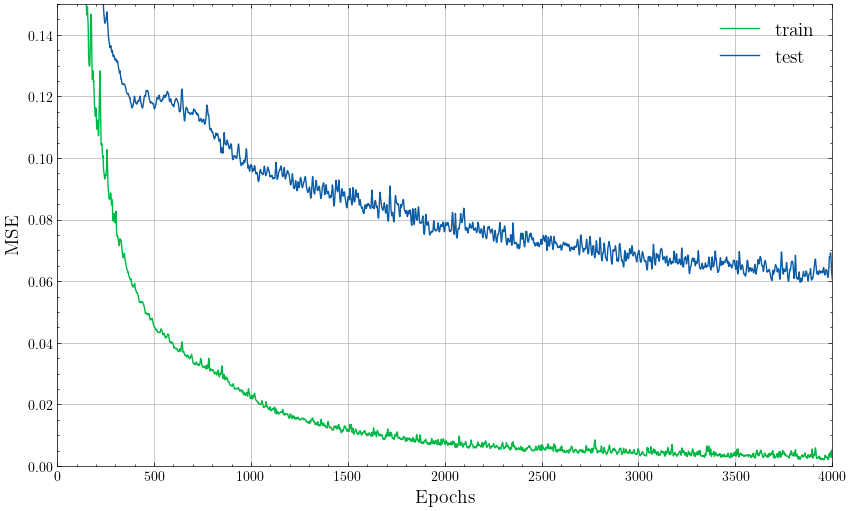

In [91]:
import scienceplots
plt.style.use('science')
plt.figure(figsize=(10,6))

plt.plot(np.arange(len(train_loss)),train_loss,label='train',color='C1')
plt.plot(np.arange(len(test_loss)),test_loss,label='test',color='C0')
#plt.axvline(x=parou_no,color='orange',label='early stop')
plt.legend(fontsize=14)
plt.xlim(0,4000)
plt.ylim(0,0.15)


plt.xlabel('Epochs',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid()


plt.savefig('C:\\Users\\lucas\\Downloads\\feature_selec_learning_curve_diff.pdf', format='pdf', bbox_inches='tight')

In [182]:
train_loss

[1.0377380132675171,
 0.9356301903724671,
 0.8730656504631042,
 0.8310614943504333,
 0.7876378774642945,
 0.7362810850143433,
 0.6744842410087586,
 0.6064746975898743,
 0.5416045784950256,
 0.48117864727973936,
 0.4249611973762512,
 0.37870959639549256,
 0.34367942810058594,
 0.3193767309188843,
 0.3035310536623001,
 0.2930168271064758,
 0.2835006594657898,
 0.27604790925979616,
 0.27043265104293823,
 0.26516943275928495,
 0.25938658118247987,
 0.254211089015007,
 0.24855673015117646,
 0.24367571771144866,
 0.23897032737731932,
 0.23458130657672882,
 0.23024891912937165,
 0.22625280320644378,
 0.22237794995307922,
 0.21876191198825837,
 0.21544069349765776,
 0.21229794025421142,
 0.20921580791473388,
 0.20610325634479523,
 0.20321055352687836,
 0.20055419206619263,
 0.197943252325058,
 0.19558001756668092,
 0.19331114590168,
 0.19117167294025422,
 0.1890835702419281,
 0.18707776069641113,
 0.18509477376937866,
 0.18312985599040985,
 0.18126034438610078,
 0.17940569519996644,
 0.1775230

### CV 

In [194]:
def permutation_importance_loss_nn(X_train,y_train,k_folds,batch,epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff):
    
    
    
    
    
    if not isinstance(X_train, pd.DataFrame):
        try:
            X_train = pd.DataFrame(X_train)
        except ValueError:
            print("X cannot be converted to a pandas DataFrame.")
    
    if not isinstance(y_train, pd.Series):
        try:
            y_train = pd.Series(y_train)
        except ValueError:
            print("X cannot be converted to a pandas Series.")        
               
    kfold=KFold(n_splits=k_folds,shuffle=True,random_state=42)

    cross_importances=np.zeros((X_train.shape[1],kfold.n_splits))
    r2_list=[]
    train_loss_fold=[[],[],[],[],[]]
    val_loss_fold=[[],[],[],[],[]]
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        
        x_train_fold=X_train.iloc[np.sort(train_idx)]
        y_train_fold=y_train.iloc[np.sort(train_idx)]
        x_val_fold=X_train.iloc[np.sort(val_idx)]
        y_val_fold=y_train.iloc[np.sort(val_idx)]
        
        train_loader_fold=make_loader(X=x_train_fold,y=y_train_fold,batch=batch)
        test_loader_fold=make_loader(X=x_val_fold,y=y_val_fold,batch=batch)

        model,loss_fn,optimizer,epochs=ini_model(epochs,
                                         learning_rate,
                                         out_channels_1,
                                         kernel_1,
                                         stride_1,
                                         out_channels_2,
                                         kernel_2,
                                         stride_2,
                                         out_channels_3,
                                         kernel_3,
                                         stride_3,
                                         hidden_size,
                                         dropout_rate,
                                         total_features,
                                         regularization_coeff) #epochs defined inside function
        
        model, train_loss_fold[fold], val_loss_fold[fold]=train_fn(TrainLoader=train_loader_fold,
                                                                            TestLoader=test_loader_fold,
                                                                            model=model,
                                                                            loss_fn=loss_fn,
                                                                            optimizer=optimizer,
                                                                            epochs=6000)
        
        r2=r2_score_model(model,test_loader_fold)
        r2_list.append(r2)
        
        
    return r2_list, train_loss_fold, val_loss_fold

In [195]:
r2_train, train_loss_fold, val_loss_fold=permutation_importance_loss_nn(X_train=x_train,
                                                              y_train=y_train
                                                              ,k_folds=5
                                                              ,batch=batch_size
                                                              ,epochs=6000,
                                         learning_rate=learning_rate,
                                         out_channels_1=out_channels_1,
                                         kernel_1=kernel_1,
                                         stride_1=stride_1,
                                         out_channels_2=out_channels_2,
                                         kernel_2=kernel_2,
                                         stride_2=stride_2,
                                         out_channels_3=out_channels_3,
                                         kernel_3=kernel_3,
                                         stride_3=stride_3,
                                         hidden_size=hidden_size,
                                         dropout_rate=dropout_rate,
                                         total_features=total_features,
                                         regularization_coeff=regularization_coeff)

In [199]:
r2_train

[0.9612917829239153,
 0.8900454754783319,
 0.9791966613632108,
 0.7265223279961799,
 0.978529512315006]

In [200]:
train_loss_list=train_loss_fold
val_loss_list=val_loss_fold

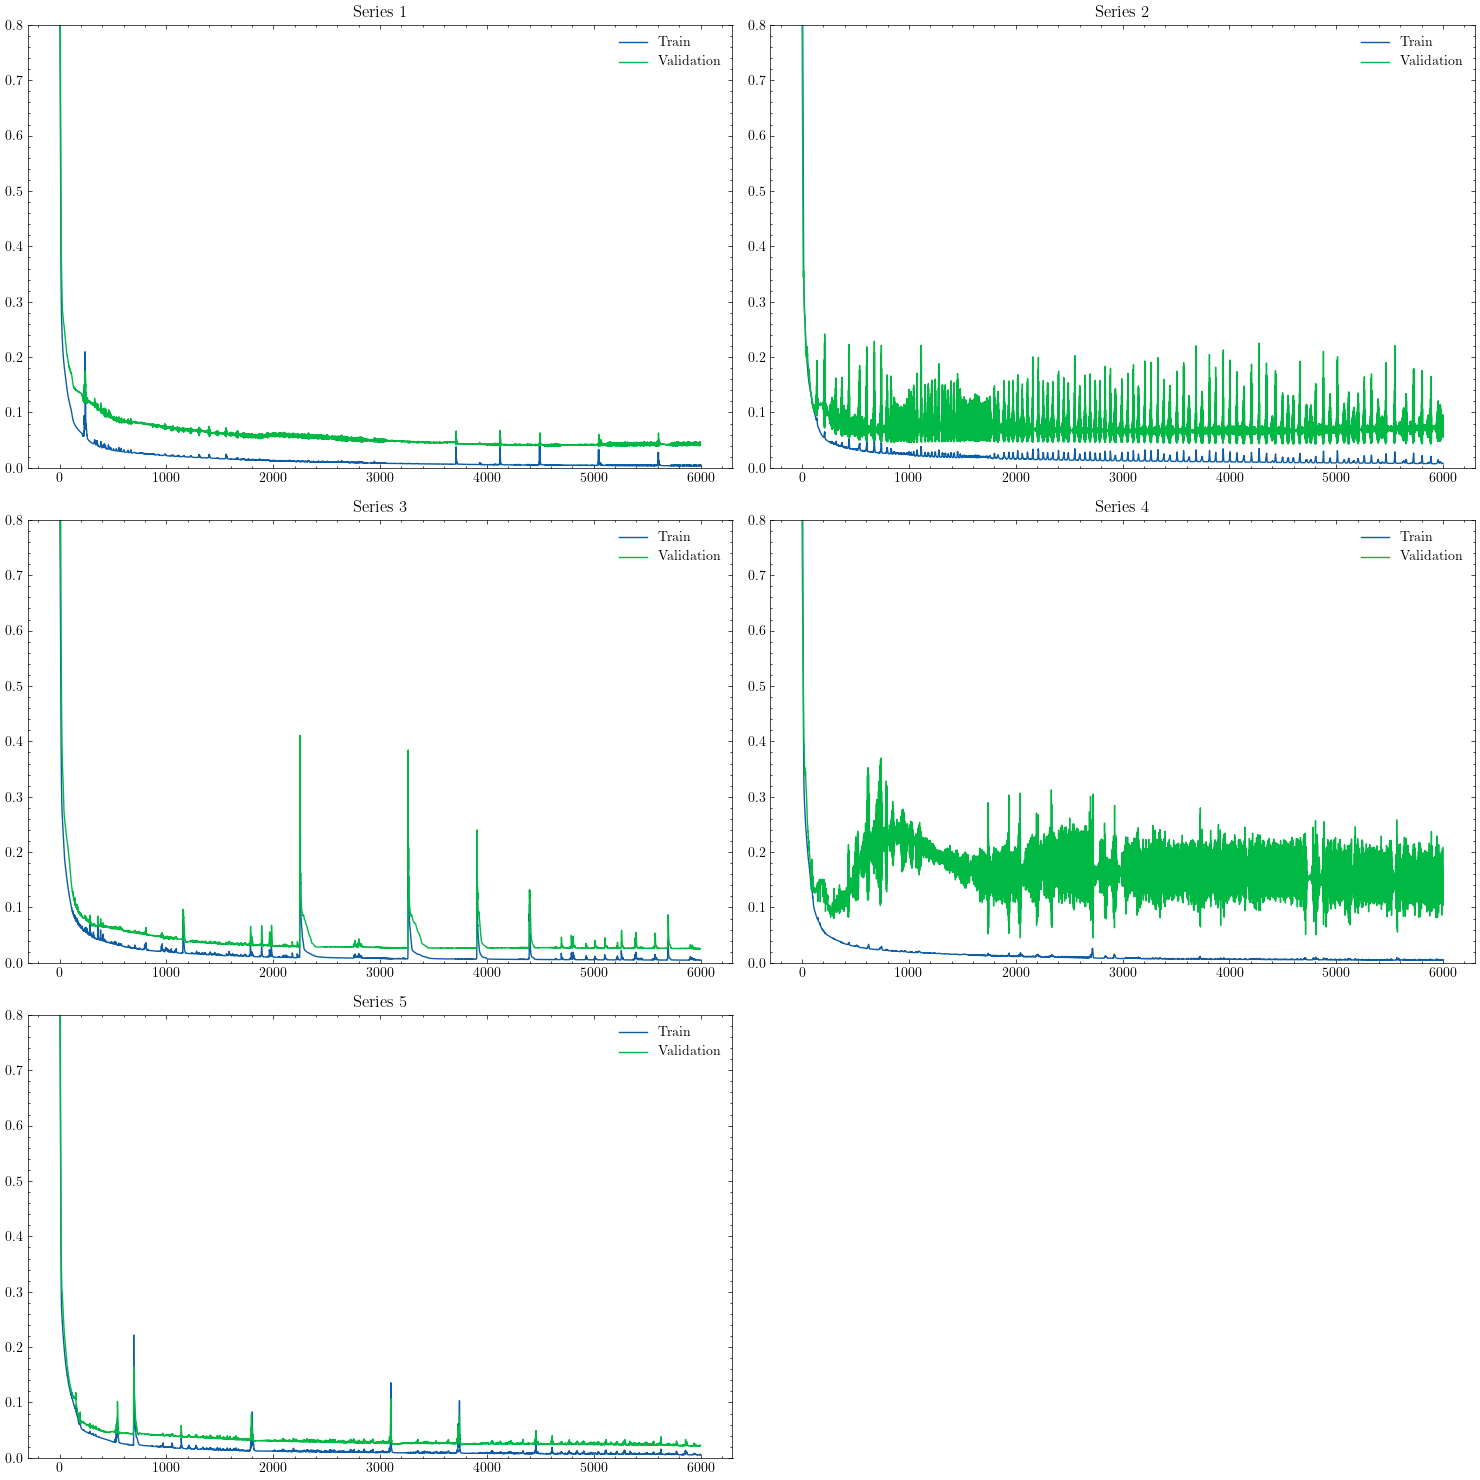

In [201]:
#loss plots on different folds
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns

# flat so i can use indexing
axs_flat = axs.flatten()

for i in range(5):
    # Plot on subplot i
    axs_flat[i].plot(np.arange(len(train_loss_list[i])), train_loss_list[i], label='Train')
    axs_flat[i].plot(np.arange(len(val_loss_list[i])), val_loss_list[i], label='Validation')
    axs_flat[i].legend()
    axs_flat[i].set_title(f'Series {i+1}')
    axs_flat[i].set_ylim([0, 0.8])

# Hide the last subplot as it's unused
axs_flat[-1].axis('off')

plt.tight_layout()
plt.show()